# Notebook 4: Hierarchical Models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [4]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [16]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

## The Beta Binomial model



In [5]:
with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    x = pm.Beta('x', alpha, beta)
    
    ks = pm.Binomial('ks', n=250, p=x)
    trace = pm.sample_prior_predictive(1000)

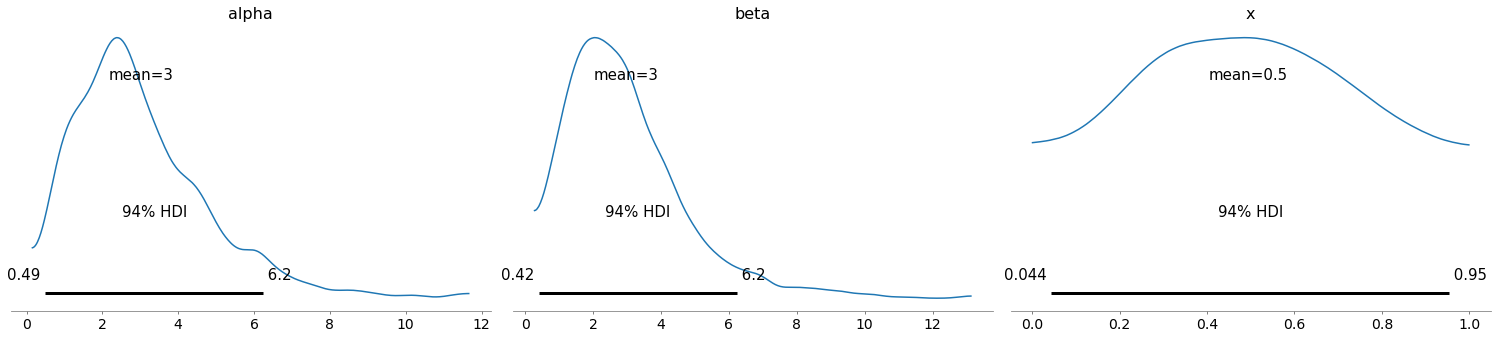

In [7]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'x'])

In [8]:
data = [140, 130, 120]

with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    xs = pm.Beta('xs', alpha, beta, shape=len(data))
    
    ks = pm.Binomial('ks', n=250, p=xs, observed=data)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


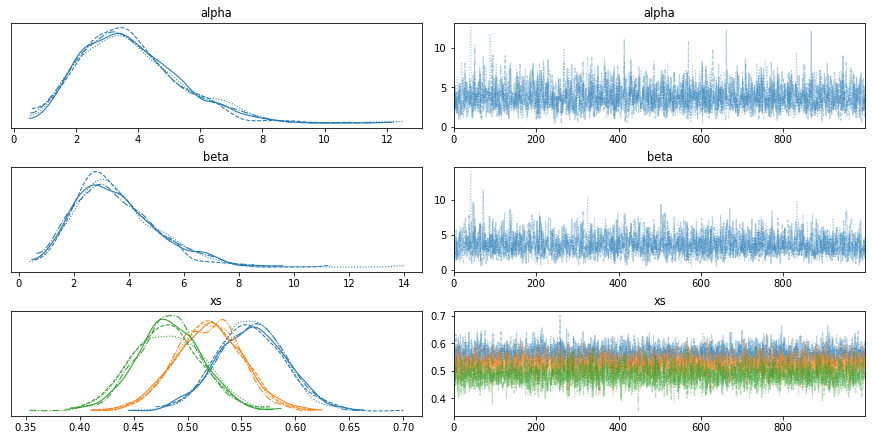

In [9]:
with model:
    az.plot_trace(trace)

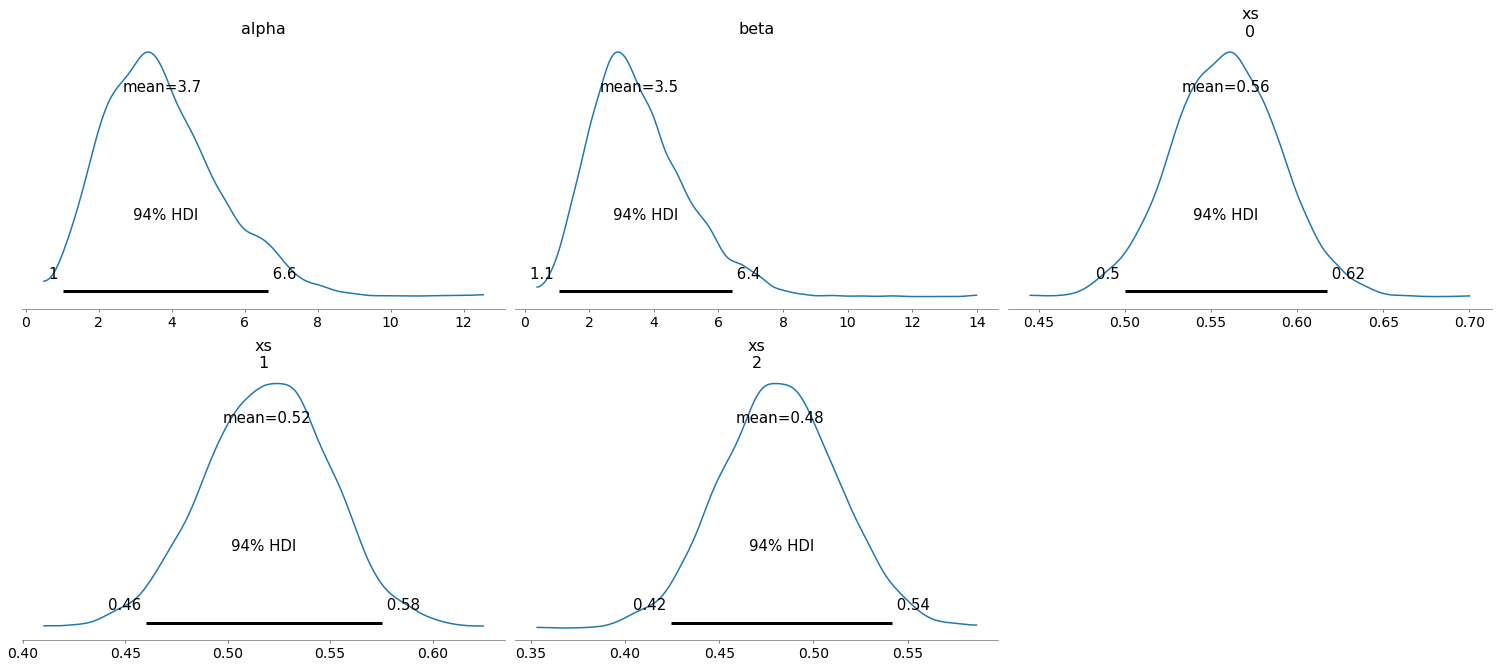

In [10]:
with model:
    az.plot_posterior(trace)

In [12]:
from scipy.stats import beta as beta_dist

alphas = trace['alpha']
betas = trace['beta']
sample_posterior_x = beta_dist.rvs(alphas, betas)
sample_posterior_x.mean()

0.5181611408719627

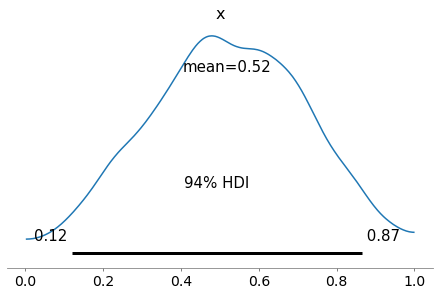

In [13]:
with model:
    az.plot_posterior(sample_posterior_x)

## Poisson model

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

1.0474523093903014

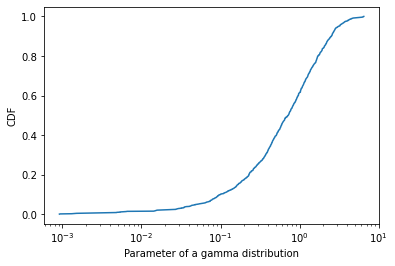

In [17]:
sample = pm.Exponential.dist(lam=1).random(size=1000)
plot_cdf(sample)
plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample)

This distribution represents radical uncertainty about the value of this distribution: it's probably between 0.1 and 10, but it could be really big or really small.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [18]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

1.007399528970912

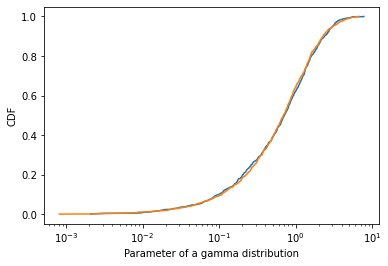

In [19]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [20]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's what the prior distribution of `mu` looks like.

In [22]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

6.635459525581014

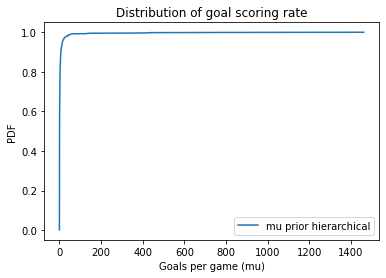

In [23]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
decorate_rate('CDF')
np.mean(sample_prior_mu)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."


The hierarchical model admits the possibility that `mu` could be orders of magnitude bigger. Unreasonable as that might seem, it's probably what we want in a non-committal prior.

Last step of the forward process, let's generate some goals.

In [29]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's the prior predictive distribution of goals.

In [31]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

7.886

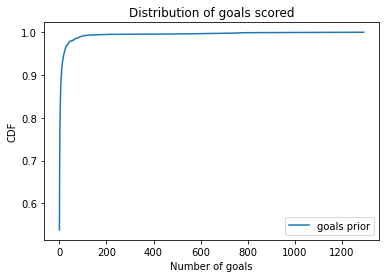

In [32]:
sample_prior_goals = trace['goals']
plot_cdf(sample_prior_goals, label='goals prior')
decorate_goals('CDF')
np.mean(sample_prior_goals)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [34]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[6])
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


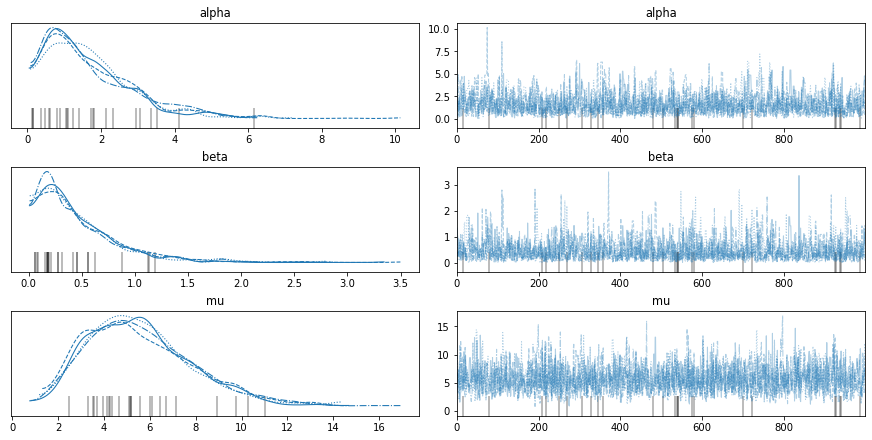

In [36]:
with model:
    az.plot_trace(trace)

Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

5.598512318984647

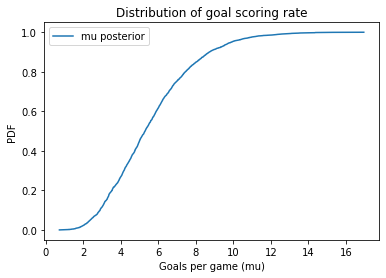

In [38]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
decorate_rate()
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [87]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_VGK = pm.Gamma('mu_VGK', alpha, beta)
    mu_WSH = pm.Gamma('mu_WSH', alpha, beta)
    goals_VGK = pm.Poisson('goals_VGK', mu_VGK, observed=[6])
    goals_WSH = pm.Poisson('goals_WSH', mu_WSH, observed=[4])
    trace = pm.sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_WSH, mu_VGK, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:06<00:00, 941.93draws/s] 


We can use `traceplot` to review the results and do some visual diagnostics.

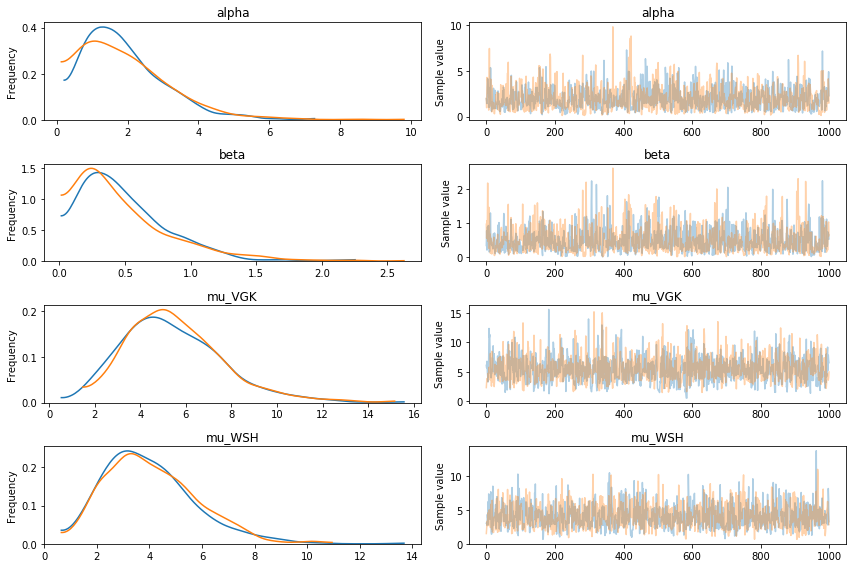

In [88]:
pm.traceplot(trace);

Here are the posterior distribitions for `mu_WSH` and `mu_VGK`.

(4.0273559918578625, 5.458780874512413)

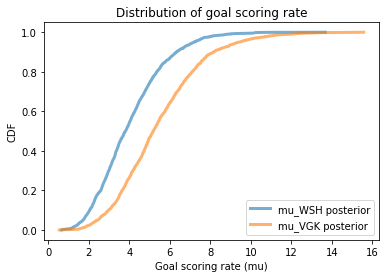

In [89]:
sample_post_mu_WSH = trace['mu_WSH']
plot_cdf(sample_post_mu_WSH, label='mu_WSH posterior')

sample_post_mu_VGK = trace['mu_VGK']
plot_cdf(sample_post_mu_VGK, label='mu_VGK posterior')

cdf_rates()
np.mean(sample_post_mu_WSH), np.mean(sample_post_mu_VGK)

On the basis of one game (and never having seen a previous game), here's the probability that Vegas is the better team.

In [90]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.7185

## More background

But let's take advantage of more information.  Here are the results from the five most recent Stanley Cup finals, ignoring games that went into overtime.

In [39]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6,2,1],
            WSH18 = [4,3,3],
           )

Here's how we can get the data into the model.

In [41]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


And here are the results.

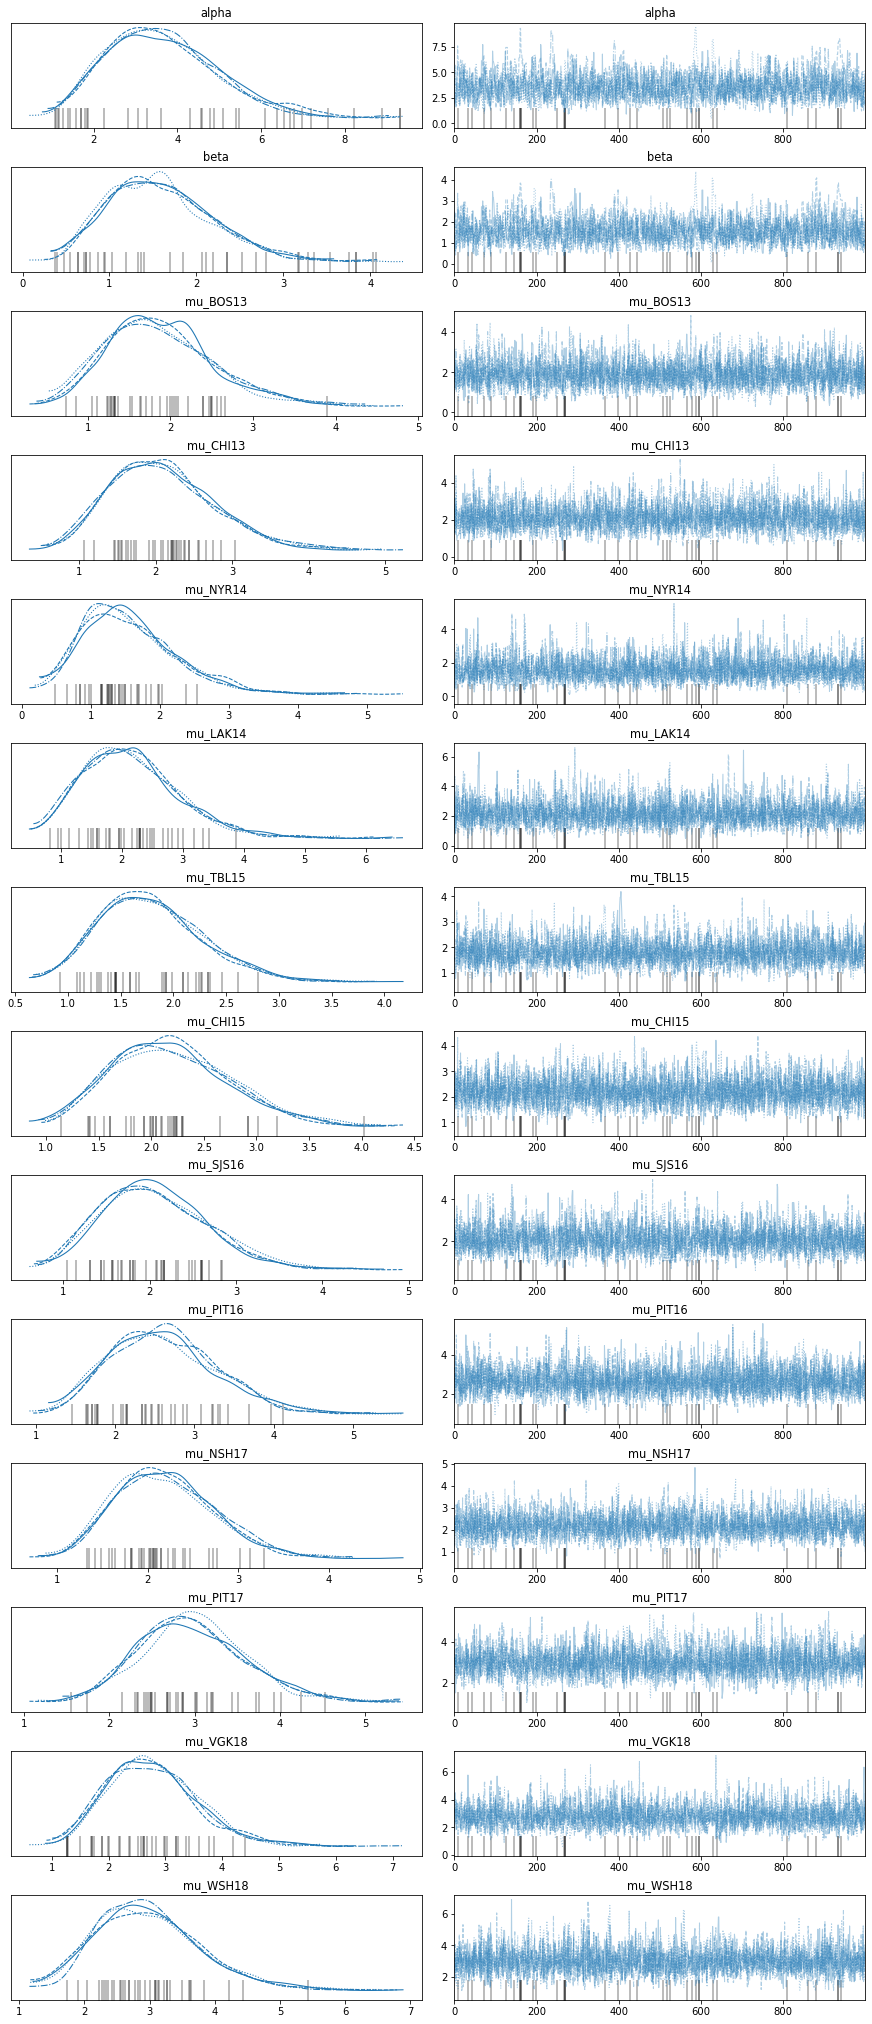

In [42]:
with model:
    az.plot_trace(trace);

Here are the posterior means.

In [94]:
sample_post_mu_VGK = trace['mu_VGK18']
np.mean(sample_post_mu_VGK)

2.738049580241473

In [95]:
sample_post_mu_WSH = trace['mu_WSH18']
np.mean(sample_post_mu_WSH)

2.9708625859213225

They are lower with the background information than without, and closer together.  Here's the updated chance that Vegas is the better team.

In [96]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.427

## Predictions

Even if Vegas is the better team, that doesn't mean they'll win the next game.

We can use `sample_ppc` to generate predictions.

In [97]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 357.01it/s]


Here are the posterior predictive distributions of goals scored.

In [98]:
WSH = post_pred['WSH18']
WSH.shape

(1000, 3)

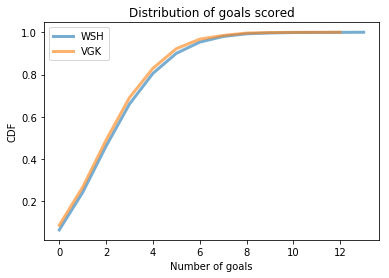

In [99]:
WSH = post_pred['WSH18'].flatten()
VGK = post_pred['VGK18'].flatten()

plot_cdf(WSH, label='WSH')
plot_cdf(VGK, label='VGK')
cdf_goals()

Here's the chance that Vegas wins the next game.

In [100]:
win = np.mean(VGK > WSH)
win

0.39666666666666667

The chance that they lose.

In [101]:
lose = np.mean(WSH > VGK)
lose

0.44766666666666666

And the chance of a tie.

In [102]:
tie = np.mean(WSH == VGK)
tie

0.15566666666666668

## Overtime!

In the playoffs, you play overtime periods until someone scores.  No stupid shootouts!

In a Poisson process with rate parameter `mu`, the time until the next event is exponential with parameter `lam = 1/mu`.

So we can take a sample from the posterior distributions of `mu`:

In [103]:
mu_VGK = trace['mu_VGK18']
mu_WSH = trace['mu_WSH18']

array([3.29949623, 2.62837258, 3.09365202, ..., 5.89303007, 2.55362515,
       3.71164352])

And generate time to score,`tts`, for each team:

In [104]:
tts_VGK  = np.random.exponential(1/mu_VGK)
np.mean(tts_VGK)

0.40026273454485134

In [105]:
tts_WSH  = np.random.exponential(1/mu_WSH)
np.mean(tts_WSH)

0.3569742547883298

Here's the chance that Vegas wins in overtime.

In [106]:
win_ot = np.mean(tts_VGK < tts_WSH)
win_ot

0.4855

Since `tts` is continuous, ties are unlikely.

In [107]:
total_win = win + tie * win_ot
total_win

0.47224283333333333

Finally, we can simulate the rest of the series and compute the probability that Vegas wins the series.

In [108]:
def flip(p):
    """Simulate a single game."""
    return np.random.random() < p

In [109]:
def series(wins, losses, p_win):
    """Simulate a series.
    
    wins: number of wins so far
    losses: number of losses so far
    p_win: probability that the team of interest wins a game
    
    returns: boolean, whether the team of interest wins the series
    """
    while True:
        if flip(p_win):
            wins += 1
        else:
            losses += 1

        if wins==4:
            return True

        if losses==4:
            return False

In [110]:
series(1, 2, total_win)

True

In [111]:
t = [series(1, 2, total_win) for i in range(1000)]
np.mean(t)

0.294